# Predicting Soccer Injuries with Machine Learning
## Baseline Models (Improved)

Jennifer Lawless    
DASC 9311: Data Science Project    
November 4, 2025  

This notebook creates baseline models to predict injuries in soccer. The baseline models include Logistic Regression, Random Forest, and XGBoost. Improvements have been made since Module 4, including feature set simplification, hyperparameter optimization, and model persistence.

## Imports and Display Settings

In [148]:
# Import necessary libraries
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import warnings
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import sys

In [149]:
# Suppress warnings and set display styles:
warnings.filterwarnings('ignore')

# Set display options:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Reproducibility and GPU Configuration

In [150]:
# Define seeds for reproducibility:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

In [151]:
# Check if GPU is available (for environments that support it):
def check_gpu_available():
    """Check if GPU is available for different libraries"""
    gpu_info = {}
    
    # Check for CUDA:
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        if result.returncode == 0:
            print("NVIDIA GPU detected")
            gpu_info['cuda'] = True
        else:
            print("No NVIDIA GPU detected")
            gpu_info['cuda'] = False
    except FileNotFoundError:
        print("nvidia-smi not found - no NVIDIA GPU available")
        gpu_info['cuda'] = False
    
    return gpu_info

# Check and display GPU availability:
gpu_info = check_gpu_available()
print(f"\nGPU will be used where supported: {gpu_info['cuda']}\n")

NVIDIA GPU detected

GPU will be used where supported: True



## Data Loading

In [152]:
# Load the dataset:
df = pd.read_csv('data_prepped.csv')
df.head()

,Injury_Next_Season,Agility_Score,Balance_Test_Score,Fitness_Score,Hamstring_Flexibility,Knee_Strength_Score,Low_Fitness,Nutrition_Quality_Score,Previous_Injury_Count,Reaction_Time_ms,Sleep_Hours_Per_Night,Sprint_Speed_10m_s,Stress_Level_Score,Stress_Sleep_Ratio,Warmup_Routine_Adherence,Wellness_Score
0,0,-0.087649,1.069297,0.491996,-0.005236,0.379259,0,0.760997,-0.411816,1.560205,1.037465,-0.227881,-0.650428,-0.899441,1,1.127931
1,0,1.843613,0.500648,1.111952,0.502136,-0.346362,0,0.716401,0.475002,0.050595,1.979228,-0.468019,-0.409281,-0.982990,1,1.340729
2,1,-0.939707,-0.058566,-0.519264,-0.475015,0.319748,0,-1.020030,0.475002,0.876025,-0.237389,-0.667398,-0.955724,-0.741810,0,-0.023700
3,0,0.586842,0.543868,0.619538,-0.780880,1.183688,0,1.657432,-0.411816,-1.026915,0.333441,0.831162,-0.219940,-0.361847,1,1.022099
4,1,0.996011,-0.104356,0.394975,-0.369953,0.275898,0,-0.301841,0.475002,-0.909176,-0.870460,-1.725425,-0.145343,0.189340,0,-0.399246


In [153]:
# Select only raw features (exclude engineered features):
engineered_features = [
    'Fitness_Score', 'Wellness_Score', 'Workload_Recovery_Ratio',
    'Stress_Sleep_Ratio', 'Low_Fitness'
]

# Create dataset without engineered features for Random Forest:
df_raw = df.copy()
for feature in engineered_features:
    if feature in df_raw.columns:
        df_raw = df_raw.drop(columns=[feature])

## Model 1: Logistic Regression

### Model Development and Evaluation

In [154]:
# Assign the features and target variables for Logistic Regression:
X_lr = df.drop(columns=['Injury_Next_Season'])
y_lr = df['Injury_Next_Season']

# Define the evaluation metrics (scorers):
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Outer CV (evaluation):
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Inner CV (hyperparameter tuning):
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Define the Logistic Regression model:
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)

# Hyperparameter grid for tuning:
param_grid = {
    'C': [0.01, 0.1, 1, 10],   # regularization strength
    'penalty': ['l1', 'l2']    # L1 = Lasso, L2 = Ridge
}

# GridSearchCV for hyperparameter tuning:
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1',   # optimize for F1 in tuning
    cv=inner_cv,
    n_jobs=-1
)

# Nested CV evaluation:
cv_results = cross_validate(
    grid, X_lr, y_lr,
    cv=outer_cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# Summarize results:
print("Model 1: Logistic Regression Results\n")
metrics_summary = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring.keys()}
print("Nested Cross-Validation Results (mean across folds):")
for metric, score in metrics_summary.items():
    print(f"{metric.capitalize()}: {score:.3f}")

# Save the best model:
best_model_lr = cv_results['estimator'][0]
import joblib
joblib.dump(best_model_lr, 'logistic_regression_model.joblib')

Model 1: Logistic Regression Results

Nested Cross-Validation Results (mean across folds):
Accuracy: 0.951
Precision: 0.953
Recall: 0.950
F1: 0.951
Roc_auc: 0.990


['logistic_regression_model.joblib']

### Mean Performance Metrics Across Folds

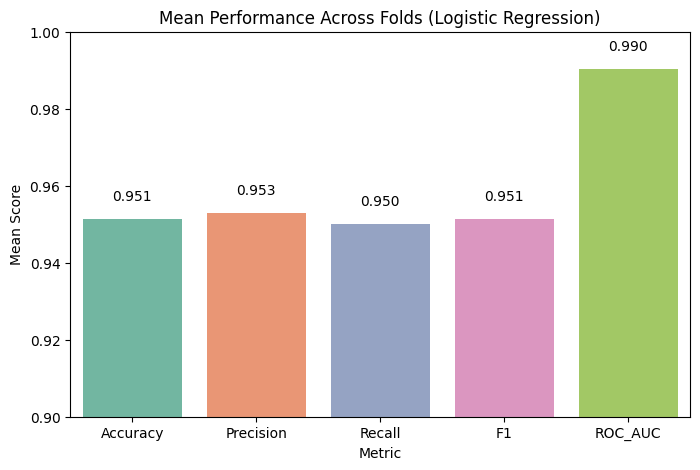

In [155]:
# Collect metrics from nested CV results:
metrics_df = pd.DataFrame({
    'Accuracy': cv_results['test_accuracy'],
    'Precision': cv_results['test_precision'],
    'Recall': cv_results['test_recall'],
    'F1': cv_results['test_f1'],
    'ROC_AUC': cv_results['test_roc_auc']
})

# Create a bar chart of mean scores:
mean_scores = metrics_df.mean().reset_index()
mean_scores.columns = ['Metric', 'Mean Score']

plt.figure(figsize=(8,5))
sns.barplot(data=mean_scores, x='Metric', y='Mean Score', palette="Set2")
plt.title("Mean Performance Across Folds (Logistic Regression)")
plt.ylim(0.9, 1.0)
for index, row in mean_scores.iterrows():
    plt.text(index, row['Mean Score'] + 0.005, f"{row['Mean Score']:.3f}", ha='center')
plt.show()

### Confusion Matrix

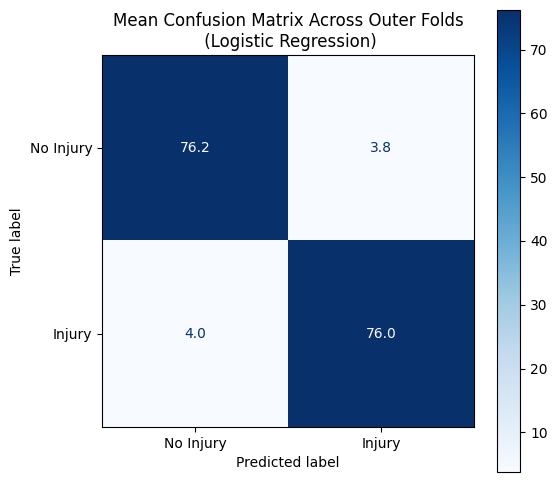

In [156]:
# Collect confusion matrices across outer folds:
cms = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_lr, y_lr)):
    best_model = cv_results['estimator'][i].best_estimator_
    X_test, y_test = X_lr.iloc[test_idx], y_lr.iloc[test_idx]
    y_pred = best_model.predict(X_test)
    cms.append(confusion_matrix(y_test, y_pred))

# Average confusion matrix across folds:
mean_cm = np.mean(cms, axis=0)

# Plot the confusion matrix:
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm,
                              display_labels=['No Injury', 'Injury'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='Blues', ax=ax, values_format=".1f")
plt.title("Mean Confusion Matrix Across Outer Folds\n (Logistic Regression)")
plt.show()

In [157]:
# Output the confusion matrix DataFrame for reference:
mean_cm_df = pd.DataFrame(mean_cm, index=['No Injury', 'Injury'], columns=['No Injury', 'Injury'])
print("Mean Confusion Matrix:")
display(mean_cm_df)

Mean Confusion Matrix:


,No Injury,Injury
No Injury,76.2,3.8
Injury,4.0,76.0


### Coefficient Plots (Feature Importance)

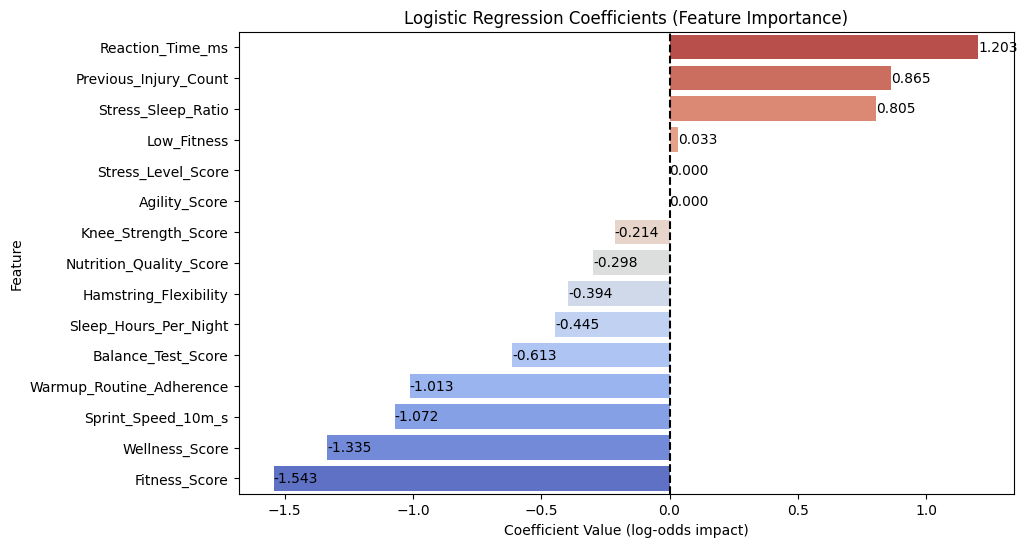

In [158]:
# Extract coefficients from the last fitted model in nested CV:
best_model = cv_results['estimator'][0].best_estimator_
coef_df = pd.DataFrame({
    'Feature': X_lr.columns,
    'Coefficient': best_model.coef_.flatten()
}).sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

# Plot it:
plt.figure(figsize=(10,6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette="coolwarm_r")
plt.axvline(0, color='black', linestyle='--')
plt.title("Logistic Regression Coefficients (Feature Importance)")
plt.xlabel("Coefficient Value (log-odds impact)")
plt.ylabel("Feature")
for index, row in coef_df.iterrows():
    plt.text(row['Coefficient'], index, f"{row['Coefficient']:.3f}", ha='left', va='center')
plt.show()

In [159]:
# Output the coefficients DataFrame for reference:
display(coef_df)

,Feature,Coefficient
0,Reaction_Time_ms,1.203318
1,Previous_Injury_Count,0.864724
2,Stress_Sleep_Ratio,0.804663
3,Low_Fitness,0.033236
4,Stress_Level_Score,0.000000
5,Agility_Score,0.000000
6,Knee_Strength_Score,-0.213604
7,Nutrition_Quality_Score,-0.298248
8,Hamstring_Flexibility,-0.394045
9,Sleep_Hours_Per_Night,-0.444838


### ROC Curves

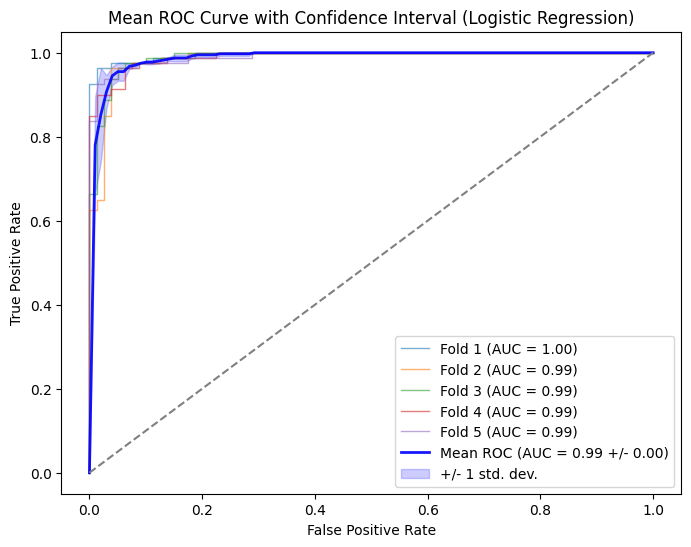

In [160]:
# Outer CV again for consistency:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Plot ROC curves for each fold and the mean ROC curve:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8,6))

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_lr, y_lr)):
    best_model = cv_results['estimator'][i].best_estimator_
    X_test, y_test = X_lr.iloc[test_idx], y_lr.iloc[test_idx]

    # Predict probabilities:
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Interpolate TPR:
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    
    # Plot each fold:
    plt.plot(fpr, tpr, lw=1, alpha=0.6, label=f"Fold {i+1} (AUC = {roc_auc:.2f})")

# Mean ROC:
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=f"Mean ROC (AUC = {mean_auc:.2f} +/- {std_auc:.2f})",
         lw=2, alpha=0.9)

# Confidence interval (+-1 std):
tprs_std = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + tprs_std, 1)
tprs_lower = np.maximum(mean_tpr - tprs_std, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='blue', alpha=0.2,
                 label='+/- 1 std. dev.')

# Plot settings:
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("Mean ROC Curve with Confidence Interval (Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Model 2: Random Forest

### Model Development and Evaluation

In [161]:
# Assign the features and target variables for Random Forest (using raw features):
X_rf = df_raw.drop(columns=['Injury_Next_Season'])
y_rf = df_raw['Injury_Next_Season']

# Define the Random Forest model:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# Hyperparameter grid for tuning (simplified and focused):
param_grid_rf = {
    'n_estimators': [100, 110],                   
    'max_depth': [5, 10, 15],                # More focused range
    'min_samples_split': [5],                # Simplified
    'min_samples_leaf': [2],                 # Simplified
    'max_features': ['sqrt']                 # Best for classification
}

# GridSearchCV for hyperparameter tuning:
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=inner_cv,
    n_jobs=-1,
    verbose=1
)

# Nested CV evaluation:
cv_results_rf = cross_validate(
    grid_rf, X_rf, y_rf,
    cv=outer_cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# Summarize results:
print("Model 2: Random Forest Results\n")
metrics_summary_rf = {metric: np.mean(cv_results_rf[f'test_{metric}']) for metric in scoring.keys()}
print("Nested Cross-Validation Results (mean across folds):")
for metric, score in metrics_summary_rf.items():
    print(f"{metric.capitalize()}: {score:.3f}")

# Save the best model:
best_model_rf = cv_results_rf['estimator'][0]
joblib.dump(best_model_rf, 'random_forest_model.joblib')

Model 2: Random Forest Results

Nested Cross-Validation Results (mean across folds):
Accuracy: 0.945
Precision: 0.952
Recall: 0.938
F1: 0.945
Roc_auc: 0.985


['random_forest_model.joblib']

In [162]:
# Output the best performing model's parameters:
best_index_rf = np.argmax(cv_results_rf['test_f1'])
best_model_rf = cv_results_rf['estimator'][best_index_rf].best_estimator_
print("Best Random Forest Model Parameters:")
for param, value in best_model_rf.get_params().items():
    print(f"{param}: {value}")

Best Random Forest Model Parameters:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 5
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 5
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: -1
oob_score: False
random_state: 42
verbose: 0
warm_start: False


### Mean Performance Metrics Across Folds

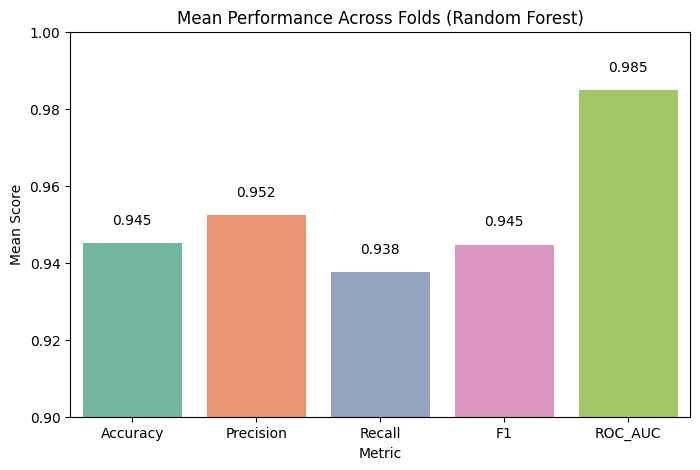

In [163]:
# Collect metrics from nested CV results:
metrics_df_rf = pd.DataFrame({
    'Accuracy': cv_results_rf['test_accuracy'],
    'Precision': cv_results_rf['test_precision'],
    'Recall': cv_results_rf['test_recall'],
    'F1': cv_results_rf['test_f1'],
    'ROC_AUC': cv_results_rf['test_roc_auc']
})

# Create a bar chart of mean scores:
mean_scores_rf = metrics_df_rf.mean().reset_index()
mean_scores_rf.columns = ['Metric', 'Mean Score']

plt.figure(figsize=(8,5))
sns.barplot(data=mean_scores_rf, x='Metric', y='Mean Score', palette="Set2")
plt.title("Mean Performance Across Folds (Random Forest)")
plt.ylim(0.9, 1.0)
for index, row in mean_scores_rf.iterrows():
    plt.text(index, row['Mean Score'] + 0.005, f"{row['Mean Score']:.3f}", ha='center')
plt.show()

### Confusion Matrix

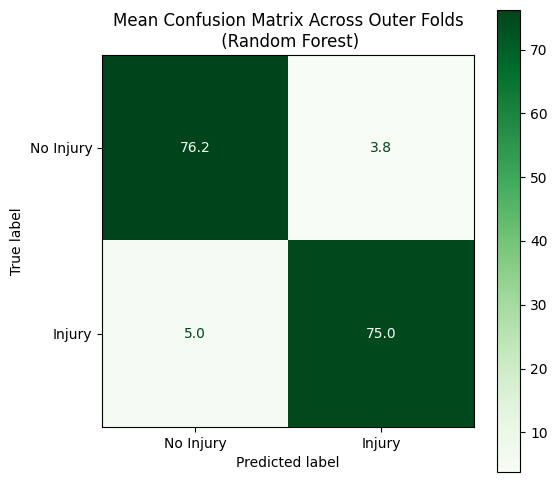

In [164]:
# Collect confusion matrices across outer folds:
cms_rf = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_rf, y_rf)):
    best_model = cv_results_rf['estimator'][i].best_estimator_
    X_test, y_test = X_rf.iloc[test_idx], y_rf.iloc[test_idx]
    y_pred = best_model.predict(X_test)
    cms_rf.append(confusion_matrix(y_test, y_pred))

# Average confusion matrix across folds:
mean_cm_rf = np.mean(cms_rf, axis=0)

# Plot the confusion matrix:
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm_rf,
                              display_labels=['No Injury', 'Injury'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='Greens', ax=ax, values_format=".1f")
plt.title("Mean Confusion Matrix Across Outer Folds\n (Random Forest)")
plt.show()

In [165]:
# Output the confusion matrix DataFrame:
mean_cm_df_rf = pd.DataFrame(mean_cm_rf, index=['No Injury', 'Injury'], columns=['No Injury', 'Injury'])
print("Mean Confusion Matrix:")
display(mean_cm_df_rf)

Mean Confusion Matrix:


,No Injury,Injury
No Injury,76.2,3.8
Injury,5.0,75.0


### Feature Importance

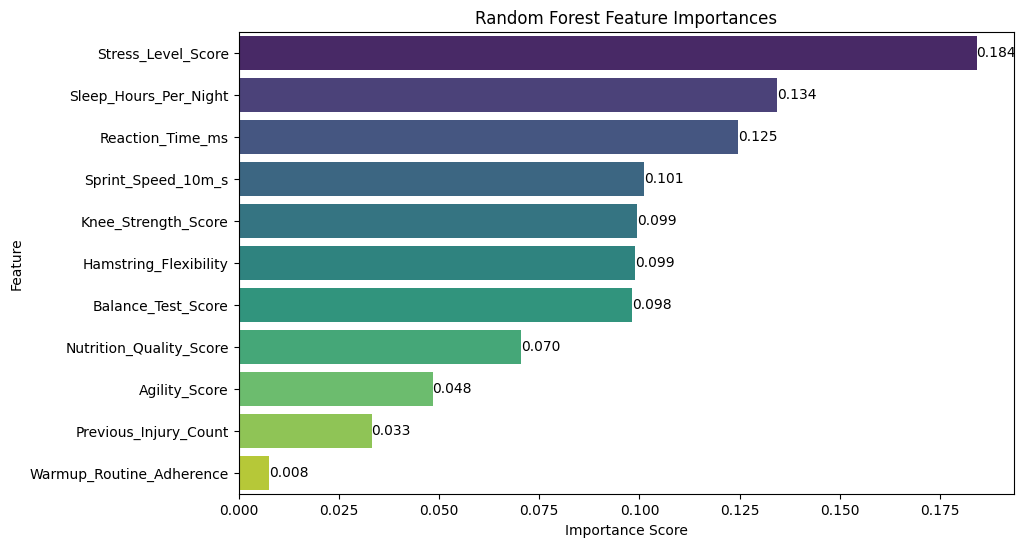

In [166]:
# Extract feature importances from the last fitted model:
best_model_rf = cv_results_rf['estimator'][0].best_estimator_
importance_df = pd.DataFrame({
    'Feature': X_rf.columns,
    'Importance': best_model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot it:
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
for index, row in importance_df.iterrows():
    plt.text(row['Importance'], index, f"{row['Importance']:.3f}", ha='left', va='center')
plt.show()

In [167]:
# Output the importances DataFrame:
display(importance_df)

,Feature,Importance
0,Stress_Level_Score,0.184116
1,Sleep_Hours_Per_Night,0.134395
2,Reaction_Time_ms,0.124556
3,Sprint_Speed_10m_s,0.101139
4,Knee_Strength_Score,0.099371
5,Hamstring_Flexibility,0.098808
6,Balance_Test_Score,0.098089
7,Nutrition_Quality_Score,0.070394
8,Agility_Score,0.048411
9,Previous_Injury_Count,0.033198


### ROC Curves

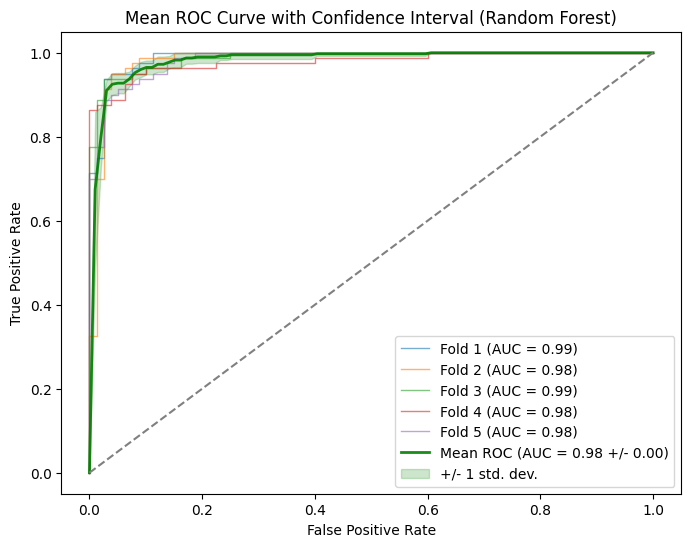

In [168]:
# Plot ROC curves for each fold and the mean ROC curve:
tprs_rf = []
aucs_rf = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8,6))

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_rf, y_rf)):
    best_model = cv_results_rf['estimator'][i].best_estimator_
    X_test, y_test = X_rf.iloc[test_idx], y_rf.iloc[test_idx]

    # Predict probabilities:
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    aucs_rf.append(roc_auc)
    
    # Interpolate TPR:
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs_rf.append(tpr_interp)
    
    # Plot each fold:
    plt.plot(fpr, tpr, lw=1, alpha=0.6, label=f"Fold {i+1} (AUC = {roc_auc:.2f})")

# Mean ROC:
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = auc(mean_fpr, mean_tpr_rf)
std_auc_rf = np.std(aucs_rf)

plt.plot(mean_fpr, mean_tpr_rf, color='g',
         label=f"Mean ROC (AUC = {mean_auc_rf:.2f} +/- {std_auc_rf:.2f})",
         lw=2, alpha=0.9)

# Confidence interval:
tprs_std_rf = np.std(tprs_rf, axis=0)
tprs_upper_rf = np.minimum(mean_tpr_rf + tprs_std_rf, 1)
tprs_lower_rf = np.maximum(mean_tpr_rf - tprs_std_rf, 0)
plt.fill_between(mean_fpr, tprs_lower_rf, tprs_upper_rf, color='green', alpha=0.2,
                 label='+/- 1 std. dev.')

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("Mean ROC Curve with Confidence Interval (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Model 3: XGBoost

### Model Development and Evaluation

In [169]:
# Configure GPU settings for XGBoost:
if gpu_info['cuda']:
    tree_method = 'auto'  # GPU acceleration
    predictor = 'gpu_predictor'
    print("XGBoost configured to use GPU")
else:
    tree_method = 'hist'  # CPU fallback
    predictor = 'cpu_predictor'
    print("XGBoost using CPU (no GPU detected)")

XGBoost configured to use GPU


In [170]:
# Assign the features and target variables for XGBoost (using raw features):
X_xgb = df.drop(columns=['Injury_Next_Season','Balance_Test_Score'])
y_xgb = df['Injury_Next_Season']

# Define the XGBoost model with GPU support:
xgb = XGBClassifier(
    random_state=RANDOM_STATE, 
    eval_metric='logloss',
    tree_method=tree_method,
    predictor=predictor,
    n_jobs=-1
)

# Hyperparameter grid for tuning (simplified and focused):
param_grid_xgb = {
    'n_estimators': [100, 110],          # Simpler range
    'max_depth': [3],                    
    'learning_rate': [0.01, 0.1],        # Simplified
    'subsample': [0.8],                  # Fixed value
    'colsample_bytree': [0.8],           # Fixed value
    'min_child_weight': [3]              # Added for better generalization
}

# GridSearchCV for hyperparameter tuning:
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=inner_cv,
    n_jobs=-1,
    verbose=1
)

# Nested CV evaluation:
cv_results_xgb = cross_validate(
    grid_xgb, X_xgb, y_xgb,
    cv=outer_cv,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1
)

# Summarize results:
print("Model 3: XGBoost Results\n")
metrics_summary_xgb = {metric: np.mean(cv_results_xgb[f'test_{metric}']) for metric in scoring.keys()}
print("Nested Cross-Validation Results (mean across folds):")
for metric, score in metrics_summary_xgb.items():
    print(f"{metric.capitalize()}: {score:.3f}")

# Save the best model:
best_model_xgb = cv_results_xgb['estimator'][0]
joblib.dump(best_model_xgb, 'xgboost_model.joblib')

Model 3: XGBoost Results

Nested Cross-Validation Results (mean across folds):
Accuracy: 0.949
Precision: 0.946
Recall: 0.953
F1: 0.949
Roc_auc: 0.988


['xgboost_model.joblib']

In [171]:
# Output the best performing model's parameters:
best_index_xgb = np.argmax(cv_results_xgb['test_f1'])
best_params_xgb = cv_results_xgb['estimator'][best_index_xgb].best_params_
print("Best Hyperparameters for XGBoost:")
for param, value in best_params_xgb.items():
    print(f"{param}: {value}")

Best Hyperparameters for XGBoost:
colsample_bytree: 0.8
learning_rate: 0.1
max_depth: 3
min_child_weight: 3
n_estimators: 110
subsample: 0.8


### Mean Performance Metrics Across Folds

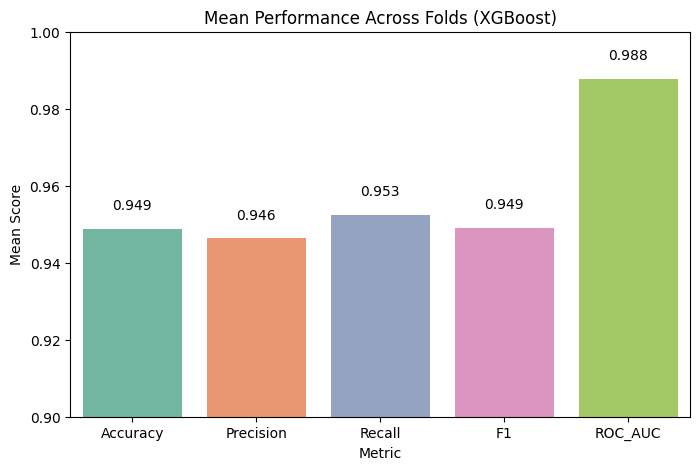

In [172]:
# Collect metrics from nested CV results:
metrics_df_xgb = pd.DataFrame({
    'Accuracy': cv_results_xgb['test_accuracy'],
    'Precision': cv_results_xgb['test_precision'],
    'Recall': cv_results_xgb['test_recall'],
    'F1': cv_results_xgb['test_f1'],
    'ROC_AUC': cv_results_xgb['test_roc_auc']
})

# Create a bar chart of mean scores:
mean_scores_xgb = metrics_df_xgb.mean().reset_index()
mean_scores_xgb.columns = ['Metric', 'Mean Score']

plt.figure(figsize=(8,5))
sns.barplot(data=mean_scores_xgb, x='Metric', y='Mean Score', palette="Set2")
plt.title("Mean Performance Across Folds (XGBoost)")
plt.ylim(0.9, 1.0)
for index, row in mean_scores_xgb.iterrows():
    plt.text(index, row['Mean Score'] + 0.005, f"{row['Mean Score']:.3f}", ha='center')
plt.show()

### Confusion Matrix

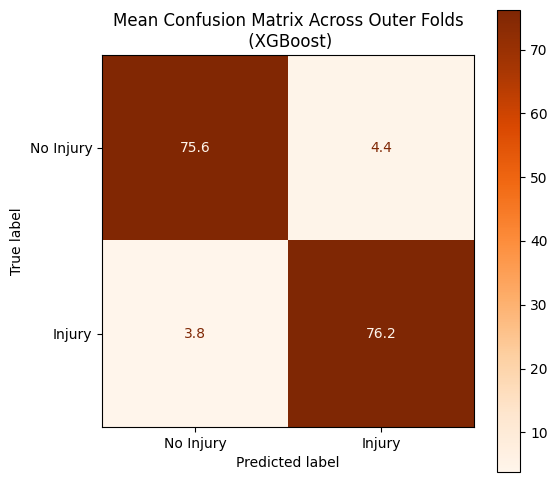

In [173]:
# Collect confusion matrices across outer folds:
cms_xgb = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_xgb, y_xgb)):
    best_model = cv_results_xgb['estimator'][i].best_estimator_
    X_test, y_test = X_xgb.iloc[test_idx], y_xgb.iloc[test_idx]
    y_pred = best_model.predict(X_test)
    cms_xgb.append(confusion_matrix(y_test, y_pred))

# Average confusion matrix across folds:
mean_cm_xgb = np.mean(cms_xgb, axis=0)

# Plot the confusion matrix:
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm_xgb,
                              display_labels=['No Injury', 'Injury'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='Oranges', ax=ax, values_format=".1f")
plt.title("Mean Confusion Matrix Across Outer Folds\n (XGBoost)")
plt.show()

In [174]:
# Output the confusion matrix DataFrame:
mean_cm_df_xgb = pd.DataFrame(mean_cm_xgb, index=['No Injury', 'Injury'], columns=['No Injury', 'Injury'])
print("Mean Confusion Matrix:")
display(mean_cm_df_xgb)

Mean Confusion Matrix:


,No Injury,Injury
No Injury,75.6,4.4
Injury,3.8,76.2


### Feature Importance

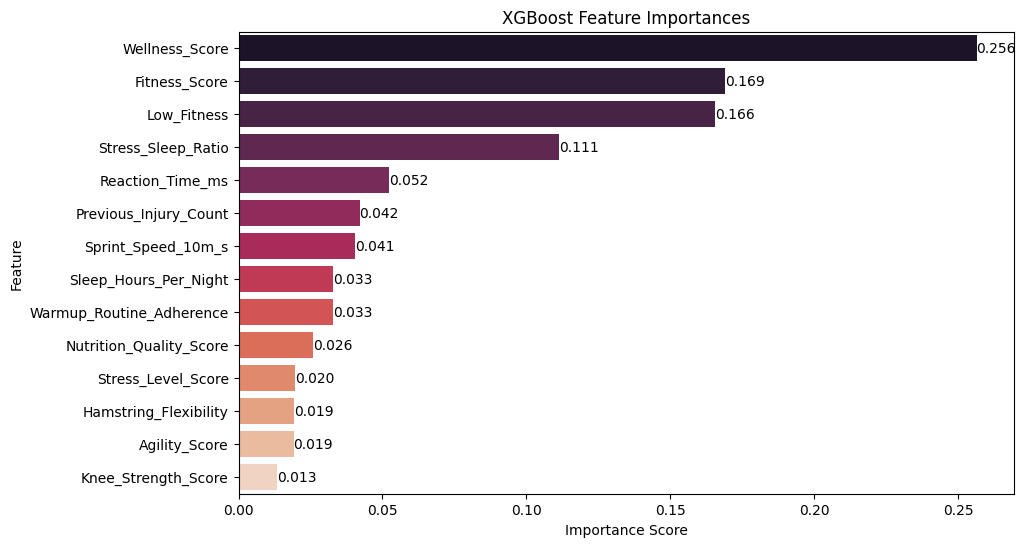

In [176]:
# Extract feature importances from the last fitted model:
best_model_xgb = cv_results_xgb['estimator'][0].best_estimator_
importance_df_xgb = pd.DataFrame({
    'Feature': X_xgb.columns,
    'Importance': best_model_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot it:
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df_xgb, x='Importance', y='Feature', palette="rocket")
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
for index, row in importance_df_xgb.iterrows():
    plt.text(row['Importance'], index, f"{row['Importance']:.3f}", ha='left', va='center')
plt.show()

In [177]:
# Output the importances DataFrame:
display(importance_df_xgb)

,Feature,Importance
0,Wellness_Score,0.256356
1,Fitness_Score,0.168957
2,Low_Fitness,0.165608
3,Stress_Sleep_Ratio,0.111213
4,Reaction_Time_ms,0.052265
5,Previous_Injury_Count,0.042030
6,Sprint_Speed_10m_s,0.040514
7,Sleep_Hours_Per_Night,0.032941
8,Warmup_Routine_Adherence,0.032683
9,Nutrition_Quality_Score,0.025942


### ROC Curves

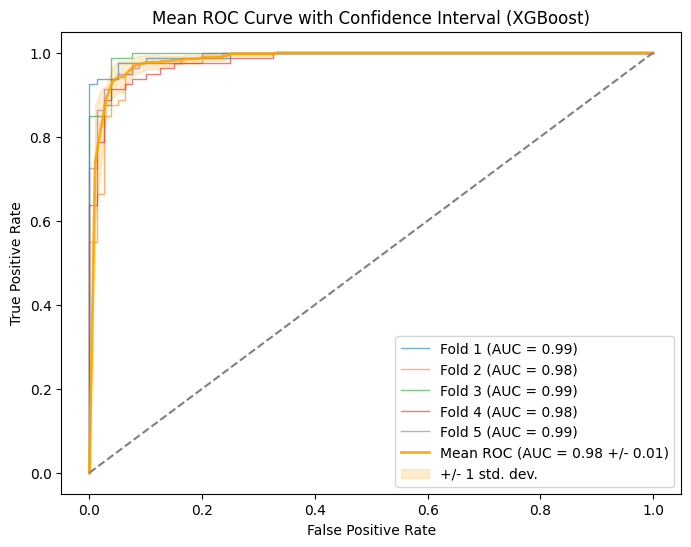

In [180]:
# Plot ROC curves for each fold and the mean ROC curve:
tprs_xgb = []
aucs_xgb = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8,6))

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_xgb, y_xgb)):
    best_model = cv_results_xgb['estimator'][i].best_estimator_
    X_test, y_test = X_xgb.iloc[test_idx], y_xgb.iloc[test_idx]

    # Predict probabilities:
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    aucs_xgb.append(roc_auc)
    
    # Interpolate TPR:
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs_xgb.append(tpr_interp)
    
    # Plot each fold:
    plt.plot(fpr, tpr, lw=1, alpha=0.6, label=f"Fold {i+1} (AUC = {roc_auc:.2f})")

# Mean ROC:
mean_tpr_xgb = np.mean(tprs_xgb, axis=0)
mean_tpr_xgb[-1] = 1.0
mean_auc_xgb = auc(mean_fpr, mean_tpr_xgb)
std_auc_xgb = np.std(aucs_xgb)

plt.plot(mean_fpr, mean_tpr_xgb, color='orange',
         label=f"Mean ROC (AUC = {mean_auc_xgb:.2f} +/- {std_auc_xgb:.2f})",
         lw=2, alpha=0.9)

# Confidence interval:
tprs_std_xgb = np.std(tprs_xgb, axis=0)
tprs_upper_xgb = np.minimum(mean_tpr_xgb + tprs_std_xgb, 1)
tprs_lower_xgb = np.maximum(mean_tpr_xgb - tprs_std_xgb, 0)
plt.fill_between(mean_fpr, tprs_lower_xgb, tprs_upper_xgb, color='orange', alpha=0.2,
                 label='+/- 1 std. dev.')

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("Mean ROC Curve with Confidence Interval (XGBoost)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()